This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


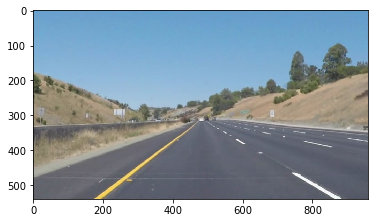

In [43]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from scipy import stats
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline


#reading in an image
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

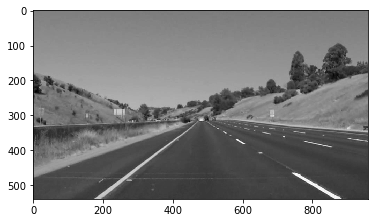

In [44]:
import math


kernel_size = 5


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)



def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
img1 = grayscale(image)
plt.imshow(img1, cmap='gray')
   

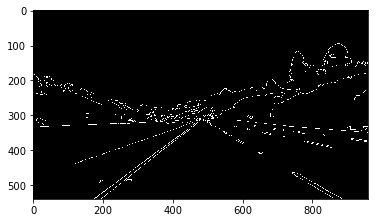

In [45]:
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

blur_gray =  gaussian_blur(img1, kernel_size)

low_threshold = 50
high_threshold = 150    

cannyImg = canny(blur_gray, low_threshold, high_threshold)    
    
plt.imshow(cannyImg, cmap='gray')

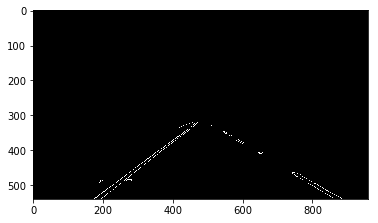

In [46]:
# Next we'll create a masked edges image using cv2.fillPoly()
 

# This time we are defining a four sided polygon to mask
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(450, 320), (490, 320), (imshape[1],imshape[0])]], dtype=np.int32)



    

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


maskedImage = region_of_interest(cannyImg, vertices)
plt.imshow(maskedImage, cmap='gray')










In [47]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
      Draw Lines as per the color and thickness mentioned
    """
    
    # Y axis coordinates
    Y_Max = img.shape[1]
    Y_Min = img.shape[0] 
    
    # Right Lane Variables
    RightGrad = []     
    RightGrad_Y = []     
    RightGrad_X = []     
    
    # Left Lane Variables
    LeftGrad = []
    LeftGrad_Y = []
    LeftGrad_X = []
    
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            gradient, intercept = np.polyfit((x1,x2), (y1,y2), 1)
            Y_Min = min(min(y1, y2), Y_Min)
            
            if (gradient < 0):
                RightGrad = RightGrad + [gradient]
                RightGrad_Y = RightGrad_Y + [y1, y2]
                RightGrad_X = RightGrad_X + [x1, x2]
            else:
                LeftGrad = LeftGrad + [gradient]
                LeftGrad_Y = LeftGrad_Y + [y1, y2]
                LeftGrad_X = LeftGrad_X + [x1, x2]
    
    
    MeanY_Right    = np.mean(RightGrad_Y)      
    MeanGrad_Right = np.mean(RightGrad)                         
    MeanX_Right    = np.mean(RightGrad_X)                
    
    MeanX_Left    = np.mean(LeftGrad_X)  
    MeanGrad_Left = np.mean(LeftGrad)              
    MeanY_Left    = np.mean(LeftGrad_Y)            

    Intercept_Left  = MeanY_Left  - (MeanGrad_Left * MeanX_Left)          
    Intercept_Right = MeanY_Right - (MeanGrad_Right * MeanX_Right)                 
    
    if ((len(LeftGrad) > 0) and (len(RightGrad) > 0)):
        X_UpperLeft = int((Y_Min - Intercept_Left) / MeanGrad_Left)
        X_LowerLeft = int((Y_Max - Intercept_Left) / MeanGrad_Left)
        X_UpperRight = int((Y_Min - Intercept_Right) / MeanGrad_Right)
        X_LowerRight = int((Y_Max - Intercept_Right) / MeanGrad_Right)
    
        cv2.line(img, (X_UpperLeft, Y_Min), (X_LowerLeft, Y_Max),  color, thickness)
        cv2.line(img, (X_UpperRight, Y_Min), (X_LowerRight, Y_Max), color, thickness)
        

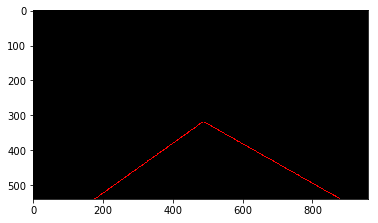

In [48]:


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img





rho          = 2
theta        = np.pi/180
threshold    = 15
min_line_len = 40
max_line_gap = 20

line_img = hough_lines(maskedImage, rho, theta, threshold, min_line_len, max_line_gap)


plt.imshow(line_img, cmap='gray')


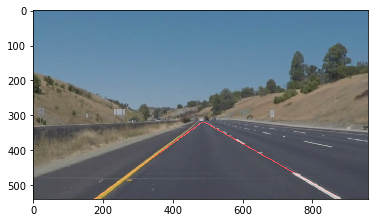

In [49]:


def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


WImg  = weighted_img(line_img, image, α=0.8, β=1., λ=0.)

plt.imshow(WImg)

